# Context


This notebook summarizes the steps in the development process for our survey model.

### The data

The model leverages a [public dataset](https://wwwn.cdc.gov/nchs/nhanes/default.aspx) from the National Health and Nutrition Examination Survey (NHANES). NHANES is a national survey that monitors the health and nutrional status of adults and children across the US. NHANCES is run by the National Center for Health Statistics (NCHS). NCHS is part of centers for disease control and prevention (CDC) and is responsible for producing vital and health statistics for the nation. The public database contains data to 40+ surveys that were each conducted 12 times between 1999-2020. 

### EDA & Data Pipeline

We explored roughly half of the survey files available in the database. For our final model we are using {XXX} different survey files spanning years of {YYY}. Our repository contains links to our jupyter notebooks used for creating our data-pipeline {ZZZ} & performing exploratory data analysis (EDA) {AAA}. 

### Model Development

#### Model Objective

The objective of our model is to predict whether a survey respondent is depressed. 
- The outcome variable is binary indicator variable called "MDD". The value is 1 if the individual has been diagnosed & is taking medication related to depression. 
- The input variables include data around demographic traits, medical & physical health, mood/behavioral data.

#### Training Phase

We explored several options during the training phase in an effort to build the best model and better understand our target sample.


1) We explored the following 6 classifiers for our model;
- Logistic Regression: XXX
- Random Forest: XXX
- Decision Tree: XXX
- K-Nearest Neighbor (KNN): XXX
- Naive Bayes: XXX
- Gradient Boosting Classifier: XXX

2) Positive class imbalance: Across our entire dataset ~4% of respondents have MDD=1. Among preganant woman, ~10% have MDD=1. We explored 3 stragies to account for this;
- SMOTE: XXX
- Test/Train Proportion: XXX
- Adding additional survey years: XXX
 
3) Segmentation: Our project is oriented around predicting PPD, hence our model focuses on predicting depression among woman that have been pregnant. We did however want to compare performance when across several groups; A) all respondents B) males only C) females only D) females that have been preganant only. This is used to understand potential differences in predicting depression among different audiences.

#### Test Phase



- Evaluation criteria: 
- Feature selection:
- Hyperparameters: 
- Error analysis:

# Model Development

## Load Packages

In [18]:
# TODO: add annotations describing usage of different modules

from operator import mod
from os import getcwd
from os.path import exists, join

import joblib
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
import pandas as pd
import numpy as np
# from ydata_profiling import ProfileReport

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression, LinearRegression
import warnings
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import  GradientBoostingClassifier
# import xgboost as xgb
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

from sklearn.metrics import recall_score

from sklearn import tree
from sklearn.decomposition import PCA, SparsePCA

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image
import warnings

from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

import altair as alt
import random
import warnings

warnings.filterwarnings('ignore')

## Load Data

In [19]:
cdc_survey = pd.read_csv('../data/cdc_nhanes_survey_responses_clean.csv')

# filter to pregnant moms
cdc_survey_pmom = cdc_survey[cdc_survey['has_been_pregnant'] == 1]
cdc_survey_pmom

,SEQN,SMQ681,SMQ690A,SMQ710,SMQ720,SMQ725,SMQ690B,SMQ740,SMQ690C,SMQ770,...,live_birth_count,age_at_first_birth,age_at_last_birth,months_since_birth,horomones_not_bc,smoked_100_cigs,currently_smoke,height_in,weight_lbs,attempt_weight_loss_1yr
8,109284,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,17.0,24.0,NaN,2.0,2.0,NaN,60.0,178.0,1.0
11,109290,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,2.0,2.0,NaN,63.0,155.0,1.0
12,109291,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,21.0,39.0,NaN,2.0,2.0,NaN,64.0,148.0,2.0
15,109295,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,18.0,24.0,NaN,2.0,2.0,NaN,63.0,137.0,2.0
18,109300,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,30.0,33.0,NaN,2.0,2.0,NaN,59.0,130.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29140,83700,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,27.0,NaN,2.0,2.0,NaN,64.0,153.0,2.0
29141,83701,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,26.0,NaN,2.0,2.0,NaN,65.0,160.0,2.0
29144,83711,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,27.0,30.0,NaN,2.0,2.0,NaN,61.0,185.0,NaN
29146,83717,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,19.0,40.0,NaN,2.0,2.0,NaN,NaN,93.0,2.0


In [9]:
np.mean(cdc_survey['MDD'])

0.04234582423122164

In [11]:
np.mean(cdc_survey_pmom['MDD'])

0.0971450716961633

In [17]:
cdc_survey.groupby(['folder'])['MDD'].sum()

folder
2013_2014         404
2015_2016         392
2017_march2020    716
Name: MDD, dtype: int64

In [18]:
cdc_survey_pmom.groupby(['folder'])['MDD'].sum()

folder
2013_2014         204
2015_2016         200
2017_march2020    348
Name: MDD, dtype: int64

## Training Step

### Features to Use

In [20]:
all_columns = [
    # Depression screener
    'little_interest_in_doing_things',
    'feeling_down_depressed_hopeless',
    'trouble_falling_or_staying_asleep',
    'feeling_tired_or_having_little_energy',
    'poor_appetitie_or_overeating',
    'feeling_bad_about_yourself',
    'trouble_concentrating',
    'moving_or_speaking_to_slowly_or_fast',
    'thoughts_you_would_be_better_off_dead',
    'difficult_doing_daytoday_tasks',
    # Alcohol & smoking
    'has_smoked_tabacco_last_5days',
    'alcoholic_drinks_past_12mo', 
    'drank_alc',
    'alc_drinking_freq',
    'alc_per_day',
    'times_with_4or5_alc',
    'times_with_8plus_alc',
    'times_with_12plus_alc',
    '4plus_alc_daily',
    'days_4plus_drinks_occasion',
    #Blood Pressure & Cholesterol
    'high_bp',
    'age_hypertension',
    'hypertension_prescription',
    'high_bp_prescription',
    'high_cholesterol',
    'cholesterol_prescription',
    #Cardiovascular Health
    'chest_discomfort',
    # Diet & Nutrition
    'how_healthy_is_your_diet',    
    'count_lost_10plus_pounds',
    'has_tried_to_lose_weight_12mo', 
    'breastfed',
    'milk_consumption_freq',
    'govmnt_meal_delivery',
    'nonhomemade_meals',
    'fastfood_meals',
    'readytoeat_meals',
    'frozen_pizza',
    #Food Security
    'emergency_food_received',
    'food_stamps_used',
    'wic_benefit_used',
    #Hospital Utilization & Access to Care
    'general_health',
    'regular_healthcare_place',
    'time_since_last_healthcare',
    'overnight_in_hospital',
    'seen_mental_health_professional',
    #Health Insurance
    'have_health_insurance',
    'have_private_insurance',
    'plan_cover_prescriptions',
    #Income
    'family_poverty_level',
    'family_poverty_level_category',
    #Medical Conditions
    'asthma',
    'anemia_treatment',
    'blood_transfusion',
    'arthritis',
    'heart_failure',
    'coronary_heart_disease',
    'angina_pectoris',
    'heart_attack',
    'stroke',
    'thyroid_issues',
    'respiratory_issues',
    'abdominal_pain',
    'gallstones',
    'gallbladder_surgery',
    'cancer',
    'dr_recommend_lose_weight',
    'dr_recommend_exercise',
    'dr_recommend_reduce_salt',
    'dr_recommend_reduce_fat',
    'currently_losing_weight',
    'currently_increase_exercise',
    'currently_reducing_salt',
    'currently_reducing_fat',
    'metal_objects',
    #Occupation
    'hours_worked',
    'over_35_hrs_worked',
    'work_schedule',
    #Physical Activity
    'vigorous_work',
    'walk_or_bicycle',
    'vigorous_recreation',
    'moderate_recreation',
    # Physical health & Medical History
    'count_days_seen_doctor_12mo',
    'duration_last_healthcare_visit',        
    'count_days_moderate_recreational_activity',   
    'count_minutes_moderate_recreational_activity',
    'count_minutes_moderate_sedentary_activity',
    'general_health_condition',    
    'has_diabetes',
    'has_overweight_diagnosis',  
    #Reproductive Health
    'regular_periods',
    'age_last_period',
    'try_pregnancy_1yr',
    'see_dr_fertility',
    'pelvic_infection',
    'pregnant_now',
    'pregnancy_count',
    'diabetes_pregnancy',
    'delivery_count',
    'live_birth_count',
    'age_at_first_birth',
    'age_at_last_birth',
    'months_since_birth',
    'horomones_not_bc',
    #Smoking
    'smoked_100_cigs',
    'currently_smoke',
    #Weight History
    'height_in',
    'weight_lbs',
    'attempt_weight_loss_1yr',
    # Demographic data
    'food_security_level_household',   
    'food_security_level_adult',    
    'monthly_poverty_index_category',
    'monthly_poverty_index',
    'count_hours_worked_last_week',
    'age_in_years',   
    'education_level',
    'is_usa_born',    
    'has_health_insurance',
    'has_health_insurance_gap'   
]
len(all_columns)

118

In [9]:
# find columns where everything is null
# need to delete those
#cdc_survey_pmom = cdc_survey_pmom[all_columns]
#columns = cdc_survey_pmom.columns[cdc_survey_pmom.notnull().any() == False]
#columns

### Create Test & Train Datasets

In [21]:
def get_model_data(original_df, columns, test_size_prop=0.2):
    """
    Function to build feature & indicator matrices for both train & test.
    """
    
    # add target column (MDD)
    cols_to_use = columns.copy()
    cols_to_use.insert(0, 'MDD')
    
    df_to_use = original_df[cols_to_use]
    
    # Create test & train data
    x = df_to_use.iloc[:,1:].values
    y = df_to_use['MDD'].values
    
    # SimpleImputer() = fill in missing values
    # note imputer may drop columns if no values exist for it
    imputer = SimpleImputer(strategy='median')  
    x = imputer.fit_transform(x)

    # RobustScaler() = scale features to remove outliers
    trans = RobustScaler()
    x = trans.fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(
        x, 
        y, 
        test_size=test_size_prop, 
        random_state=42
    ) 
    
    return x_train, x_test, y_train, y_test

## Test Step

In [22]:
def plot_confusion_matrix(y_test, pred_labels):
    """
    Function that displays a confusion matrix for provided true and predicted classes
    """
    #print(f'cover type 1 and type 2 total correct {np.sum(np.diag(metrics.confusion_matrix(y_test, pred_labels))[:2])}')

    cm = confusion_matrix(y_test, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5,5))
    disp = disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')    
    plt.grid(False)
    plt.show()
    return

def get_performance_df(label_actual, label_pred, model_name):
    """
    Function to calculate performance metrics for model.
    Includes precision, recal, F1, & support.
    """
    # create classification report
    result_table = classification_report(label_actual, label_pred, output_dict=True)
    result_table = pd.DataFrame.from_dict(result_table)

    # store for later
    accuracies = result_table['accuracy']

    # rename grouping
    result_table.columns = [
        'depressed_no',
        'depressed_yes',
        'accuracy',
        'macro_avg',
        'weighted_avg'
    ]

    # create dataframe with 1 row per grouping
    result_table.drop(labels = 'accuracy', axis = 1, inplace=True)
    result_table = result_table.transpose()
    result_table['accuracy'] = list(accuracies)
    result_table = result_table.reset_index()
    result_table.rename(columns = {'index':'grouping'},inplace=True)
    result_table['model'] = model_name
    result_table = result_table[['model','grouping','precision','recall','f1-score','support','accuracy']]
    return result_table

def baseline_models(
    x_train, 
    y_train, 
    x_test, 
    y_test,
    do_smote=True,
    show_confusion_matrix=False,
    show_score_dataframe=False,
    show_all_groupings=False):
    """
    Function that trains and makes predictions using 5 of the classifiers went over during the class.
    Meant as a helper function for easier testing of different modeling pipelines.
    """

    #  do_smote
    if do_smote == True:
        sm = SMOTE(random_state=42)
        x_train, y_train = sm.fit_resample(x_train, y_train)

    # K-Nearest Neighbors
    knn = KNeighborsClassifier()
    knn.fit(x_train, y_train)
    pred_labels_knn  = knn.predict(x_test)
    score_knn = get_performance_df(y_test, pred_labels_knn,'Knn')
    
    # Logistic Regression
    lm = LogisticRegression()
    lm.fit(x_train, y_train)
    pred_labels_lr  = lm.predict(x_test)
    score_lr = get_performance_df(y_test, pred_labels_lr,'Logistic Regression')
        
    # Bernoulii Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(x_train, y_train)
    pred_labels_bnb  = bnb.predict(x_test)
    score_bnb = get_performance_df(y_test, pred_labels_bnb,'Bernoulli Naive Bayes')    
        
    # Gaussian Naive Bayes
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    pred_labels_gnb  = gnb.predict(x_test)
    score_gnb = get_performance_df(y_test, pred_labels_gnb,'Gaussian Naive Bayes')    

    # Random Forest
    rf = RandomForestClassifier(random_state=0)
    rf.fit(x_train, y_train)
    pred_labels_rf  = rf.predict(x_test)
    predictions_posterior_rf = rf.predict_proba(x_test)
    score_rf = get_performance_df(y_test, pred_labels_rf,'Random Forest')   
    
    #Decision Tree
    dt = DecisionTreeClassifier()
    dt.fit(x_train, y_train)
    pred_labels_dt = dt.predict(x_test)
    score_dt = get_performance_df(y_test, pred_labels_dt,'Decision Tree')

    #Gradient Boosting Classifier
    gb = GradientBoostingClassifier()
    gb.fit(x_train, y_train)
    pred_labels_gb = gb.predict(x_test)
    score_gb = get_performance_df(y_test, pred_labels_gb,'Gradient Boosting Classifier')
    
#     #XGBoost
#     xgboost = xgb.XGBClassifier()
#     xgboost.fit(x_train, y_train)
#     pred_labels_xgboost = gbt.predict(x_test)
#     score_xgboost = get_performance_df(y_test, pred_labels_xgboost,'XGBoost')
    
    # make dataframe with scores
    scores = pd.concat([score_knn, score_lr, score_bnb, score_gnb, score_rf, score_dt, score_gb])
    scores = scores.sort_values(by = 'recall', ascending=False)
    
    if show_score_dataframe:
        display(scores.style.set_table_attributes('style="font-size: 17px"').hide_index())
    
    if show_confusion_matrix:
        print('\nK-Nearest Neighbors Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_knn)
        print('Logistic Regression Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_lr)
        print('Bernoulli Naive Bayes Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_bnb)
        print('Gaussian Naive Bayes Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_gnb)
        print('Random Forest Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_rf)
        print('Decision Tree Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_dt)
        print('Gradient Boosting Confusion Matrix')
        plot_confusion_matrix(y_test, pred_labels_gbt)
#         print('XGBoost Confusion Matrix')
#         plot_confusion_matrix(y_test, pred_labels_xgboost)

    if not show_all_groupings:
        scores = scores[scores['grouping'] == 'macro_avg']

    return scores

### K-fold cross validation 

In [23]:
def evaluate_models_w_val(x, y, k=5, shuffle=False, do_smote = True):

    models = {
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(),
        'Logistic Regression': LogisticRegression(),
        'Gaussian Naive Bayes': GaussianNB(),
        'Bernoulli Naive Bayes': BernoulliNB(),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'Gradient Boosting': GradientBoostingClassifier()
    }
    
    # Create an empty dataframe to store the evaluation scores
    scores_df = pd.DataFrame(columns=['Model', 'Recall', 'Precision', 'F1 Score'])
    
        # do_smote
    if do_smote == True:
        sm = SMOTE(random_state=42)
        x, y = sm.fit_resample(x, y)
        
    # Implement K-fold validation
    kf = KFold(n_splits=k, shuffle=False)
    for model_name, model in models.items():

        rc_score=[]
        prec_score=[]
        f_score=[]

        for train_index , test_index in kf.split(x):
            X_train , X_test = x[train_index,:],x[test_index,:]
            y_train , y_test = y[train_index] , y[test_index]

            model.fit(X_train,y_train)
            pred_values = model.predict(X_test)

            recall = recall_score(pred_values , y_test)
            rc_score.append(recall)
            precision = precision_score(pred_values , y_test)
            prec_score.append(precision)
            f1 = f1_score(pred_values , y_test)
            f_score.append(f1)


        avg_recall_score = sum(rc_score)/k
        avg_precision_score = sum(prec_score)/k
        avg_f1_score = sum(f_score)/k

        scores_df = scores_df.append({
            'Model': model_name,
            'Recall': avg_recall_score,
            'Precision': avg_precision_score,
            'F1 Score': avg_f1_score
        }, ignore_index=True)
    
    return scores_df

### Baseline models (just depression screener)

In [24]:
x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_pmom,
    columns = all_columns[0:10] # just depression screener
)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6192, 10)
(1549, 10)
(6192,)
(1549,)


In [25]:
baseline_model = baseline_models(x_train, y_train, x_test, y_test, do_smote=False)
baseline_model[['model','precision','recall','f1-score']]

,model,precision,recall,f1-score
2,Bernoulli Naive Bayes,0.614506,0.675232,0.632390
2,Gaussian Naive Bayes,0.618641,0.660506,0.633699
2,Decision Tree,0.595202,0.560086,0.570532
2,Random Forest,0.688099,0.543840,0.555191
2,Logistic Regression,0.685605,0.538270,0.546401
2,Knn,0.655004,0.534046,0.539683
2,Gradient Boosting Classifier,0.719752,0.519854,0.513698


In [96]:
baseline_model_with_smote = baseline_models(x_train, y_train, x_test, y_test, do_smote=True)
baseline_model_with_smote[['model','precision','recall','f1-score']]

,model,precision,recall,f1-score
2,Logistic Regression,0.592019,0.693521,0.597918
2,Bernoulli Naive Bayes,0.585532,0.678157,0.590212
2,Gaussian Naive Bayes,0.596015,0.666054,0.610442
2,Gradient Boosting Classifier,0.634470,0.616144,0.624201
2,Knn,0.568707,0.605145,0.577523
2,Decision Tree,0.609058,0.576795,0.588096
2,Random Forest,0.610641,0.558832,0.571549


In [16]:
evaluate_models_w_val(x_train, y_train, do_smote=True, k=6)

,Model,Recall,Precision,F1 Score
0,Random Forest,0.702907,0.612768,0.652122
1,SVM,0.602951,0.720526,0.581355
2,Logistic Regression,0.577201,0.620185,0.491410
3,Gaussian Naive Bayes,0.595150,0.520733,0.483998
4,Bernoulli Naive Bayes,0.597697,0.665642,0.575936
5,KNN,0.626896,0.776553,0.643307
6,Decision Tree,0.654172,0.599217,0.620457
7,Gradient Boosting,0.651022,0.571244,0.606278


### Baseline models (all variables)

In [17]:
x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_pmom,
    columns = all_columns
)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2729, 116)
(683, 116)
(2729,)
(683,)


In [16]:
baseline_model = baseline_models(x_train, y_train, x_test, y_test, do_smote=False)
baseline_model[['model','precision','recall','f1-score']]

,model,precision,recall,f1-score
0,Bernoulli Naive Bayes,0.621495,0.689608,0.641671
0,Gaussian Naive Bayes,0.615217,0.665439,0.631984
0,Decision Tree,0.576176,0.567952,0.571595
0,Gradient Boosting Classifier,0.619722,0.523357,0.523049
0,Logistic Regression,0.588745,0.515895,0.510511
0,Knn,0.567623,0.514271,0.508729
0,Random Forest,0.652065,0.512490,0.501503


In [17]:
baseline_model = baseline_models(x_train, y_train, x_test, y_test, do_smote=True)
baseline_model[['model','precision','recall','f1-score']]

,model,precision,recall,f1-score
0,Logistic Regression,0.590836,0.696392,0.597041
0,Gaussian Naive Bayes,0.586315,0.687306,0.590851
0,Bernoulli Naive Bayes,0.597820,0.673374,0.613396
0,Knn,0.561444,0.643814,0.550770
0,Gradient Boosting Classifier,0.719203,0.580624,0.607471
0,Decision Tree,0.557711,0.567455,0.561674
0,Random Forest,0.649332,0.543310,0.554640


In [18]:
evaluate_models_w_val(x_train, y_train, do_smote=True, k=6)

,Model,Recall,Precision,F1 Score
0,Random Forest,0.850015,0.690106,0.742192
1,SVM,0.614295,0.826263,0.626147
2,Logistic Regression,0.614806,0.779384,0.619150
3,Gaussian Naive Bayes,0.567750,0.782321,0.595448
4,Bernoulli Naive Bayes,0.625517,0.697728,0.633613
5,KNN,0.583008,0.989801,0.658400
6,Decision Tree,0.629581,0.698796,0.655428
7,Gradient Boosting,0.718351,0.621825,0.652397


### Test Different Train/Test Proportion

Just using depression screener cols

In [24]:
# compare performance with various train splits from [20%, 80%]
test_size_props = np.arange(0.2,0.8,0.01)

In [25]:
### Without SMOTE

# create base table
model_perf = pd.DataFrame(columns = ['model','precision','recall','f1-score','support'])

# iterate across prop splits and save performance
for prop in test_size_props:

    x_train, x_test, y_train, y_test = get_model_data(
        original_df = cdc_survey_pmom,
        columns = all_columns[0:10],
        test_size_prop = prop
    )
    
    mod_data = baseline_models(x_train, y_train, x_test, y_test, do_smote=False)
    mod_data['test_size_prop'] = prop
    model_perf = model_perf.append(mod_data)
    
### With SMOTE

# create base table
model_perf_smote = pd.DataFrame(columns = ['model','precision','recall','f1-score','support'])

# iterate across prop splits and save performance
for prop in test_size_props:

    x_train, x_test, y_train, y_test = get_model_data(
        original_df = cdc_survey_pmom,
        columns = all_columns[0:10],
        test_size_prop = prop
    )
    
    mod_data = baseline_models(x_train, y_train, x_test, y_test, do_smote=True)
    mod_data['test_size_prop'] = prop
    model_perf_smote = model_perf_smote.append(mod_data)    

In [26]:
alt.Chart(model_perf).mark_line().encode(
    x='test_size_prop:Q',
    y='f1-score:Q',
    color='model:N',
)

alt.Chart(...)

In [27]:
alt.Chart(model_perf_smote).mark_line().encode(
    x='test_size_prop:Q',
    y='f1-score:Q',
    color='model:N',
)

alt.Chart(...)

### Test Different # of columns

#### Get column feature importances when including all

In [31]:
def get_random_forest_n_top_features(train_data=x_train, 
                                     train_labels=y_train):
    """
    A model that trains a random forest model and returns the feature importances as a dataframe.
    The index of the row corresponds to the column index in the initial array
    """
    
    # fit random forest and print accuracy
    rf = RandomForestClassifier(random_state=0)
    rf.fit(train_data, train_labels)
   
    # list feature importances
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    feature_importances = pd.DataFrame({'Feature': all_columns,'Coefficient': importances})
    feature_importances = feature_importances.sort_values('Coefficient',ascending=False)
    
    return feature_importances

In [33]:
feature_importances = get_random_forest_n_top_features()
feature_importances

,Feature,Coefficient
28,age_in_years,0.092835
19,count_minutes_moderate_sedentary_activity,0.069866
11,alcoholic_drinks_past_12mo,0.056657
1,feeling_down_depressed_hopeless,0.048181
12,how_healthy_is_your_diet,0.040809
26,monthly_poverty_index,0.040175
9,difficult_doing_daytoday_tasks,0.039431
27,count_hours_worked_last_week,0.038932
29,education_level,0.038772
13,count_lost_10plus_pounds,0.038085


#### Test model performance when using top N features

In [34]:
### Without SMOTE

model_perf_nfeatures = pd.DataFrame(columns = ['model','precision','recall','f1-score','support'])

for number_of_features in list(range(1,len(all_columns))):
    
    # features to use
    # use top N features
    features = list(feature_importances.Feature[:number_of_features])
    
    x_train, x_test, y_train, y_test = get_model_data(
        original_df = cdc_survey_pmom,
        columns = features,
        test_size_prop = 0.2
    )
    
    mod_data = baseline_models(x_train, y_train, x_test, y_test, do_smote=False)
    mod_data['n_features'] = number_of_features
    model_perf_nfeatures = model_perf_nfeatures.append(mod_data)    
    
### With SMOTE    
    
model_perf_nfeatures_smote = pd.DataFrame(columns = ['model','precision','recall','f1-score','support'])

for number_of_features in list(range(1,len(all_columns))):
    
    # features to use
    # use top N features
    features = list(feature_importances.Feature[:number_of_features])
    
    x_train, x_test, y_train, y_test = get_model_data(
        original_df = cdc_survey_pmom,
        columns = features,
        test_size_prop = 0.2
    )
    
    mod_data = baseline_models(x_train, y_train, x_test, y_test, do_smote=True)
    mod_data['n_features'] = number_of_features
    model_perf_nfeatures_smote = model_perf_nfeatures_smote.append(mod_data)        

In [35]:
alt.Chart(model_perf_nfeatures).mark_line().encode(
    x='n_features:Q',
    y='f1-score:Q',
    color='model:N',
)

alt.Chart(...)

In [36]:
alt.Chart(model_perf_nfeatures_smote).mark_line().encode(
    x='n_features:Q',
    y='f1-score:Q',
    color='model:N',
)

alt.Chart(...)

#### Test model performance when using N features randomly selected

In [37]:
model_perf_nfeatures_rand = pd.DataFrame(columns = ['model','precision','recall','f1-score','support'])

# randomly sample N features
for number_of_features in list(range(1,len(all_columns)+1)):

    # repeat each N 10 times
    for repeat in range(10):
        columns_to_use = random.sample(all_columns, number_of_features)

        x_train, x_test, y_train, y_test = get_model_data(
            original_df = cdc_survey_pmom,
            columns = columns_to_use,
            test_size_prop = 0.2
        )

        mod_data = baseline_models(x_train, y_train, x_test, y_test, do_smote=False)
        mod_data['n_features'] = number_of_features
        model_perf_nfeatures_rand = model_perf_nfeatures_rand.append(mod_data)      

In [38]:
model_perf_nfeatures_rand

,model,precision,recall,f1-score,support,n_features
0,Gaussian Naive Bayes,0.588157,0.541844,0.550559,683,1.0
0,Knn,0.594407,0.537628,0.545475,683,1.0
0,Logistic Regression,0.450952,0.500000,0.474211,683,1.0
0,Bernoulli Naive Bayes,0.450952,0.500000,0.474211,683,1.0
0,Random Forest,0.450952,0.500000,0.474211,683,1.0
...,...,...,...,...,...,...
0,Decision Tree,0.549324,0.547344,0.548283,683,33.0
0,Gradient Boosting Classifier,0.619722,0.523357,0.523049,683,33.0
0,Logistic Regression,0.588745,0.515895,0.510511,683,33.0
0,Knn,0.567623,0.514271,0.508729,683,33.0


In [39]:
# model_perf_nfeatures_rand[(model_perf_nfeatures_rand['model'] == "Knn") & (model_perf_nfeatures_rand['n_features'] == 1)]

In [40]:
alt.Chart(model_perf_nfeatures_rand).mark_point().encode(
    x='n_features:Q',
    y='f1-score:Q',
    color='model:N',
).facet(
    facet='model:N',
    columns=2
)

alt.FacetChart(...)

### Test Different Segments

In [19]:
#All responders
x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey,
    columns = all_columns
)

baseline_model = baseline_models(x_train, y_train, x_test, y_test, do_smote=True)
all_results = baseline_model[['model','precision','recall','f1-score']]
all_results['segment']='all'
all_results

,model,precision,recall,f1-score,segment
0,Logistic Regression,0.579423,0.827837,0.586850,all
0,Gaussian Naive Bayes,0.554764,0.780761,0.524130,all
0,Bernoulli Naive Bayes,0.566512,0.755171,0.572428,all
0,Knn,0.544460,0.671431,0.539039,all
0,Gradient Boosting Classifier,0.727957,0.593955,0.629529,all
0,Decision Tree,0.553741,0.572478,0.560990,all
0,Random Forest,0.813637,0.537040,0.557578,all


In [20]:
#Men only

cdc_survey_men = cdc_survey[cdc_survey['is_male'] == 1]

x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_men,
    columns = all_columns
)

baseline_model = baseline_models(x_train, y_train, x_test, y_test, do_smote=True)
men_results=baseline_model[['model','precision','recall','f1-score']]
men_results['segment']='men'
men_results

,model,precision,recall,f1-score,segment
0,Logistic Regression,0.561305,0.811331,0.564294,men
0,Bernoulli Naive Bayes,0.552429,0.767660,0.550052,men
0,Gaussian Naive Bayes,0.537267,0.756889,0.493394,men
0,Knn,0.529528,0.632181,0.521755,men
0,Decision Tree,0.589932,0.627463,0.604690,men
0,Gradient Boosting Classifier,0.653517,0.577989,0.601833,men
0,Random Forest,0.694309,0.549745,0.575083,men


In [21]:
#Women only

cdc_survey_women = cdc_survey[cdc_survey['is_male'] == 0]

x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_women,
    columns = all_columns
)

baseline_model = baseline_models(x_train, y_train, x_test, y_test, do_smote=True)
women_results=baseline_model[['model','precision','recall','f1-score']]
women_results['segment']='women'
women_results

,model,precision,recall,f1-score,segment
0,Logistic Regression,0.619839,0.781723,0.645550,women
0,Bernoulli Naive Bayes,0.600598,0.755603,0.616108,women
0,Gaussian Naive Bayes,0.574070,0.747775,0.543830,women
0,Knn,0.550155,0.635989,0.542123,women
0,Decision Tree,0.618209,0.622924,0.620498,women
0,Gradient Boosting Classifier,0.730975,0.596777,0.630077,women
0,Random Forest,0.698562,0.527682,0.534551,women


In [22]:
#Pregnant women only

x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_pmom,
    columns = all_columns
)

baseline_model = baseline_models(x_train, y_train, x_test, y_test, do_smote=True)
preg_results=baseline_model[['model','precision','recall','f1-score']]
preg_results['segment']='mothers'
preg_results

,model,precision,recall,f1-score,segment
0,Logistic Regression,0.615577,0.724959,0.634298,mothers
0,Gaussian Naive Bayes,0.570787,0.683381,0.545167,mothers
0,Bernoulli Naive Bayes,0.604620,0.669001,0.621745,mothers
0,Knn,0.541998,0.607131,0.511123,mothers
0,Decision Tree,0.557237,0.563239,0.559882,mothers
0,Gradient Boosting Classifier,0.737772,0.561482,0.583102,mothers
0,Random Forest,0.681142,0.532443,0.537705,mothers


In [23]:
merge_results=pd.concat([all_results, men_results, women_results, preg_results])


line=alt.Chart(merge_results).mark_line(size=1).encode(
    x=alt.X('segment', title = ''),
    y=alt.Y('recall', title='Recall', scale=alt.Scale(domain=[0, .9])),
    color='model:N'
).properties(
                width=200,
                height=200
                )

points=alt.Chart(merge_results).mark_point().encode(
    x=alt.X('segment'),
    y=alt.Y('recall', title='Recall', scale=alt.Scale(domain=[0, .9])),
    color='model:N')


recall = alt.layer(line, points, data=merge_results)
recall

alt.LayerChart(...)

### Test Using Additional Survey Years

In [19]:
cdc_survey_pmom.groupby(['folder'])['MDD'].sum()

folder
2013_2014         204
2015_2016         200
2017_march2020    348
Name: MDD, dtype: int64

In [21]:
all_columns[0:10]

['little_interest_in_doing_things',
 'feeling_down_depressed_hopeless',
 'trouble_falling_or_staying_asleep',
 'feeling_tired_or_having_little_energy',
 'poor_appetitie_or_overeating',
 'feeling_bad_about_yourself',
 'trouble_concentrating',
 'moving_or_speaking_to_slowly_or_fast',
 'thoughts_you_would_be_better_off_dead',
 'difficult_doing_daytoday_tasks']

In [39]:
len(y_train)

6192

In [43]:
x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_pmom,
    columns = all_columns[0:10] # just depression screener
)

baseline_model = baseline_models(x_train, y_train, x_test, y_test, do_smote=False)
print(f"Baseline Models Using 10 Dep Screener Cols (2013 - 2020) \
       \nNumber Observations in Train Data: {len(y_train)}")
baseline_model.reset_index()[['model','precision','recall','f1-score']]

Baseline Models Using 10 Dep Screener Cols (2013 - 2020)        
Number Observations in Train Data: 6192


,model,precision,recall,f1-score
0,Bernoulli Naive Bayes,0.614506,0.675232,0.632390
1,Gaussian Naive Bayes,0.618641,0.660506,0.633699
2,Decision Tree,0.590846,0.559006,0.568736
3,Random Forest,0.688099,0.543840,0.555191
4,Logistic Regression,0.685605,0.538270,0.546401
5,Knn,0.655004,0.534046,0.539683
6,Gradient Boosting Classifier,0.719752,0.519854,0.513698


In [44]:
x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_pmom[cdc_survey_pmom['folder'] == "2017_march2020"],
    columns = all_columns[0:10] # just depression screener
)

baseline_model = baseline_models(x_train, y_train, x_test, y_test, do_smote=False)
print(f"Baseline Models Using 10 Dep Screener Cols (2017 - 2020) \
       \nNumber Observations in Train Data: {len(y_train)}")
baseline_model.reset_index()[['model','precision','recall','f1-score']]

Baseline Models Using 10 Dep Screener Cols (2017 - 2020)        
Number Observations in Train Data: 2729


,model,precision,recall,f1-score
0,Bernoulli Naive Bayes,0.609595,0.672248,0.627428
1,Gaussian Naive Bayes,0.619179,0.657007,0.633433
2,Decision Tree,0.577559,0.549465,0.557616
3,Logistic Regression,0.653195,0.524981,0.525183
4,Random Forest,0.552096,0.512648,0.506990
5,Knn,0.516733,0.506154,0.500418
6,Gradient Boosting Classifier,0.522612,0.502593,0.485650


### Error Analysis

Two Objectives;
- Measure the precision, recall, & f1-score for each class (i.e depressed & non-depressed separately)
- EDA on the features across TP, TN, FP, FN

#### Measure the precision, recall, & f1-score for each class (i.e depressed & non-depressed separately)

**Just depression screener**

In [97]:
x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_pmom,
    columns = all_columns[0:10] # just depression screener
)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6192, 10)
(1549, 10)
(6192,)
(1549,)


In [101]:
bm = baseline_models(x_train, y_train, x_test, y_test, do_smote=False, show_all_groupings=True)
bm[bm['grouping'] == 'macro_avg'][['model','precision','recall','f1-score','grouping']]

,model,precision,recall,f1-score,grouping
2,Bernoulli Naive Bayes,0.614506,0.675232,0.632390,macro_avg
2,Gaussian Naive Bayes,0.618641,0.660506,0.633699,macro_avg
2,Decision Tree,0.584097,0.553077,0.561986,macro_avg
2,Random Forest,0.688099,0.543840,0.555191,macro_avg
2,Logistic Regression,0.685605,0.538270,0.546401,macro_avg
2,Knn,0.655004,0.534046,0.539683,macro_avg
2,Gradient Boosting Classifier,0.719752,0.519854,0.513698,macro_avg


In [102]:
bm[bm['grouping'] == 'depressed_yes'][['model','precision','recall','f1-score','grouping']]

,model,precision,recall,f1-score,grouping
1,Bernoulli Naive Bayes,0.292776,0.484277,0.364929,depressed_yes
1,Gaussian Naive Bayes,0.305310,0.433962,0.358442,depressed_yes
1,Decision Tree,0.260417,0.157233,0.196078,depressed_yes
1,Random Forest,0.470588,0.100629,0.165803,depressed_yes
1,Logistic Regression,0.466667,0.088050,0.148148,depressed_yes
1,Knn,0.406250,0.081761,0.136126,depressed_yes
1,Gradient Boosting Classifier,0.538462,0.044025,0.081395,depressed_yes


In [103]:
bm[bm['grouping'] == 'depressed_no'][['model','precision','recall','f1-score','grouping']]

,model,precision,recall,f1-score,grouping
0,Gradient Boosting Classifier,0.901042,0.995683,0.946001,depressed_no
0,Logistic Regression,0.904542,0.988489,0.944655,depressed_no
0,Random Forest,0.905611,0.987050,0.944578,depressed_no
0,Knn,0.903757,0.986331,0.943240,depressed_no
0,Decision Tree,0.907777,0.948921,0.927893,depressed_no
0,Gaussian Naive Bayes,0.931973,0.887050,0.908957,depressed_no
0,Bernoulli Naive Bayes,0.936236,0.866187,0.899851,depressed_no


**All columns**

In [106]:
x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_pmom,
    columns = all_columns # all columns
)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

bm = baseline_models(x_train, y_train, x_test, y_test, do_smote=True, show_all_groupings=True)

(6192, 116)
(1549, 116)
(6192,)
(1549,)


In [107]:
bm[bm['grouping'] == 'macro_avg'][['model','precision','recall','f1-score','grouping']]

,model,precision,recall,f1-score,grouping
2,Logistic Regression,0.606640,0.728112,0.615576,macro_avg
2,Bernoulli Naive Bayes,0.608781,0.689505,0.626282,macro_avg
2,Gaussian Naive Bayes,0.565029,0.667228,0.529321,macro_avg
2,Knn,0.539551,0.597337,0.508503,macro_avg
2,Decision Tree,0.584092,0.593308,0.588209,macro_avg
2,Gradient Boosting Classifier,0.751060,0.586786,0.616888,macro_avg
2,Random Forest,0.748243,0.557857,0.577293,macro_avg


In [108]:
bm[bm['grouping'] == 'depressed_yes'][['model','precision','recall','f1-score','grouping']]

,model,precision,recall,f1-score,grouping
1,Gaussian Naive Bayes,0.182580,0.685535,0.288360,depressed_yes
1,Logistic Regression,0.258373,0.679245,0.374350,depressed_yes
1,Bernoulli Naive Bayes,0.276527,0.540881,0.365957,depressed_yes
1,Knn,0.154275,0.522013,0.238164,depressed_yes
1,Decision Tree,0.251397,0.283019,0.266272,depressed_yes
1,Gradient Boosting Classifier,0.588235,0.188679,0.285714,depressed_yes
1,Random Forest,0.588235,0.125786,0.207254,depressed_yes


In [109]:
bm[bm['grouping'] == 'depressed_no'][['model','precision','recall','f1-score','grouping']]

,model,precision,recall,f1-score,grouping
0,Random Forest,0.908251,0.989928,0.947332,depressed_no
0,Gradient Boosting Classifier,0.913885,0.984892,0.948061,depressed_no
0,Decision Tree,0.916788,0.903597,0.910145,depressed_no
0,Bernoulli Naive Bayes,0.941034,0.838129,0.886606,depressed_no
0,Logistic Regression,0.954907,0.776978,0.856803,depressed_no
0,Knn,0.924827,0.672662,0.778842,depressed_no
0,Gaussian Naive Bayes,0.947479,0.648921,0.770282,depressed_no


#### EDA on the features across TP, TN, FP, FN

In [ ]:
# inputs: 
#    Labels: {label_actual, label_pred}
#    Column names
#    y_test matrix
# output: 
#   bivariate distribution plot across; 1) is correct prediction & 2) a specific feature column

In [293]:
# Set figure size for the notebook
plt.rcParams["figure.figsize"]=8,6

# set seaborn whitegrid theme
sns.set(style="whitegrid")


def label_pred(row):
    """
    Function that labels prediction cases into TP, TN, FP, FN
    """
    if row['y_actual'] == row['y_pred']:
        if row['y_actual'] == 1:
            result = 'TP'
        else:
            result = 'TN'
    else: 
        if row['y_actual'] == 1:
            result = 'FN'
        else:
            result = 'FP'

    return result



def create_error_plots(
    y_actuals,
    y_predictions,
    x_test_matrix,
    x_test_columns,
    columns_to_plot,
    show_bar_plot=True,
    show_density_plot=True):
    """
    Function that creates bi-variate plots comparing TP, TN, FP, FN for each desired feature column.
    """
    
    ### Create dataframe of predictions & feature 
    
    # create dataframe with actuals & predictions w/ labels
    prediction_labels = pd.DataFrame(columns = ['y_actual','y_pred'])
    prediction_labels['y_actual'] = y_actuals
    prediction_labels['y_pred'] = y_predictions
    prediction_labels['label'] = prediction_labels.apply(label_pred, axis = 1)

    # feature df 
    feature_df = pd.DataFrame(x_test_matrix, columns = x_test_columns)

    # combine into 1
    pred_data = pd.concat([prediction_labels, feature_df], axis = 1)

    ### Bi-variate plots
    for column in columns_to_plot:
    
        if show_density_plot:
            ## Density plot
            sns.kdeplot(
                data=pred_data, 
                x=column, 
                hue="label", 
                cut=0, 
                common_norm=False, 
                alpha=0.4
            )

        if show_bar_plot:
            ## barplot
            # create % of total column by group
            group_data = pred_data.groupby(['label',column])['y_actual'].count().reset_index()
            group_data['Pct of Total'] = group_data['y_actual'] / group_data.groupby('label')['y_actual'].transform('sum')

            sns.catplot(
                data=group_data, 
                kind="bar",
                x=column, 
                y="Pct of Total", 
                hue="label",
                alpha = 0.8
            )

        plt.show()

In [294]:
x_train, x_test, y_train, y_test = get_model_data(
    original_df = cdc_survey_pmom,
    columns = all_columns[0:10] # just depression screener
)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6192, 10)
(1549, 10)
(6192,)
(1549,)


In [289]:
# model 
lm = LogisticRegression()
lm.fit(x_train, y_train)
pred_labels_lr  = lm.predict(x_test)

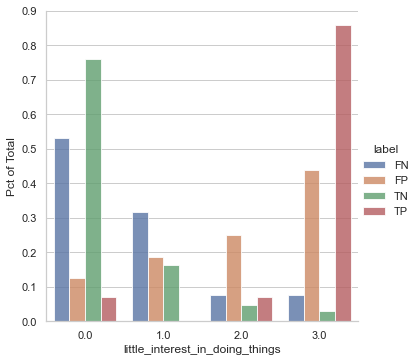

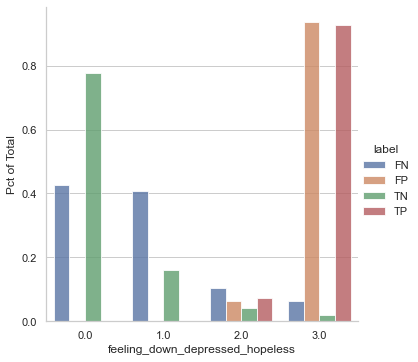

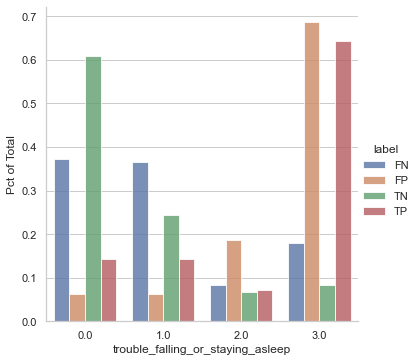

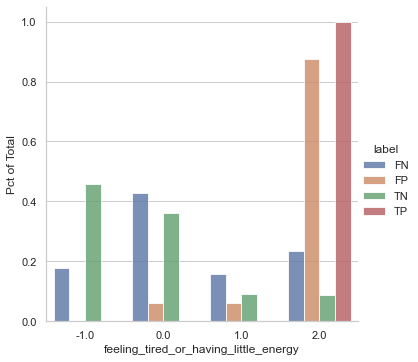

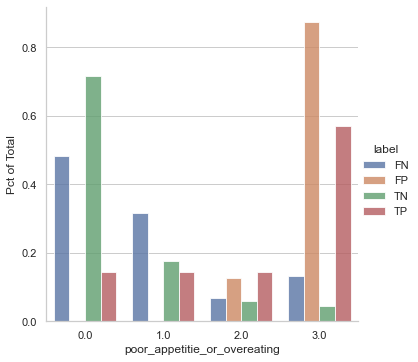

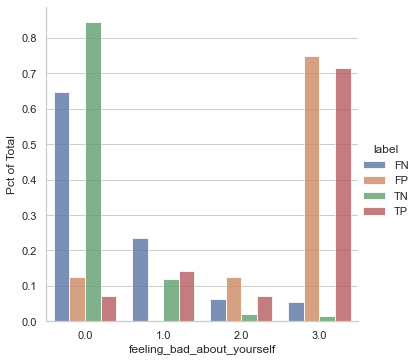

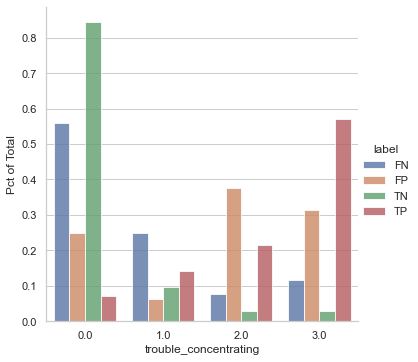

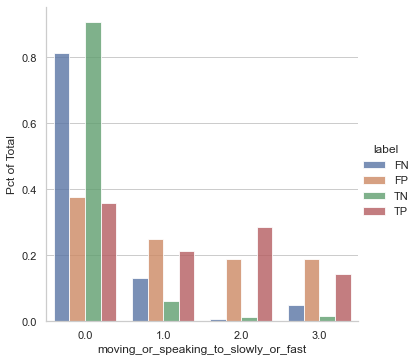

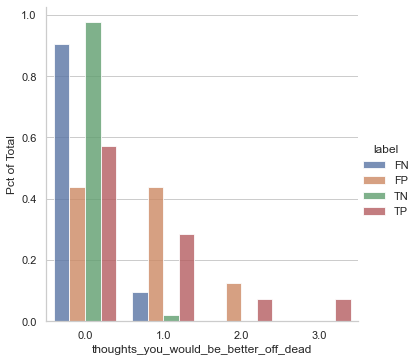

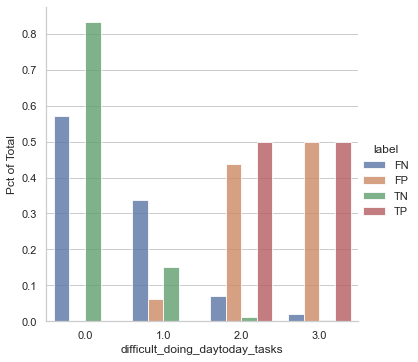

In [295]:
create_error_plots(
    y_actuals = y_test,
    y_predictions = pred_labels_lr,
    x_test_matrix = x_test,
    x_test_columns = all_columns[0:10],
    columns_to_plot = all_columns[0:10],
    show_density_plot=False
)